<a href="https://colab.research.google.com/github/shyuwang/Time-Series-Forecasting/blob/main/store-item-demand-forecasting/2_ModelBuilding_Single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 10.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=6ef0a093b59c0b338a68b1b4261dcc4a1efb643839c17ce33499673e31b42bd5
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [2]:
# Import SparkSession
from pyspark.sql import SparkSession

# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Check Spark Session Information
# spark

In [3]:
from pyspark.sql.types import *
from google.colab import drive

# Mount google drive
drive.mount('/content/drive')

# Path of training set on Google drive
train_path = '/content/drive/MyDrive/demand-forecasting-at-scale-data/train.csv'
 
# Structure of the training data set
train_schema = StructType([
  StructField('Date', DateType()),
  StructField('Store', IntegerType()),
  StructField('Item', IntegerType()),
  StructField('Sales', IntegerType())
  ])
 
# Read the training file into a dataframe
train = spark.read.csv(
  train_path, 
  header=True, 
  schema=train_schema
  )

train.createOrReplaceTempView('train')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Building model using a single item-store combination to familiarize with the prophet package.

## Step 1:

Retrieve data for a single item-store combination

In [29]:
# Day level sales for this item-store combo
query = """
select
  cast(Date as date) as ds
  ,Sales as y
from train
where store = 1
and item = 1
order by ds
"""
# Convert to pandas dataframe
history_pd = spark.sql(query).toPandas()

print(history_pd.shape)
print(history_pd.head())

(1826, 2)
           ds   y
0  2013-01-01  13
1  2013-01-02  11
2  2013-01-03  14
3  2013-01-04  13
4  2013-01-05  10


## Step 2:
Train a prophet model.

Based on EDA, it is very likely that there are
- linear overall growth pattern
- weekly and yearly seasonal patterns
  - likely multiplicative seasonality as it grows as the overall sales growth

In [22]:
from prophet import Prophet

In [21]:
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

model.fit(history_pd)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnjlt1_g/loze2vmb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnjlt1_g/kcnj4bto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79827', 'data', 'file=/tmp/tmpqnjlt1_g/loze2vmb.json', 'init=/tmp/tmpqnjlt1_g/kcnj4bto.json', 'output', 'file=/tmp/tmpqnjlt1_g/prophet_model8m128dm1/prophet_model-20230217213158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:31:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Step 3:

Build a 90-day forecast.

In [23]:
# Define a dataset including both historical dates and 90 days further than the last historical date
future_pd = model.make_future_dataframe(
    periods=90,
    freq='d',
    include_history=True
)

forecast_pd = model.predict(future_pd)

In [30]:
print(forecast_pd.shape)
print(forecast_pd.head())

(1916, 19)
          ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2013-01-01  15.603350    1.376772   18.883962    15.603350    15.603350   
1 2013-01-02  15.609047    1.664238   19.342205    15.609047    15.609047   
2 2013-01-03  15.614744    2.815140   19.540863    15.614744    15.614744   
3 2013-01-04  15.620441    4.073612   20.431562    15.620441    15.620441   
4 2013-01-05  15.626138    5.014904   21.482981    15.626138    15.626138   

   multiplicative_terms  multiplicative_terms_lower  \
0             -0.356016                   -0.356016   
1             -0.325670                   -0.325670   
2             -0.292309                   -0.292309   
3             -0.216307                   -0.216307   
4             -0.118294                   -0.118294   

   multiplicative_terms_upper    weekly  weekly_lower  weekly_upper    yearly  \
0                   -0.356016 -0.088840     -0.088840     -0.088840 -0.267176   
1                   -0.325670 -0.

## Step 4:

Examine forecast components.

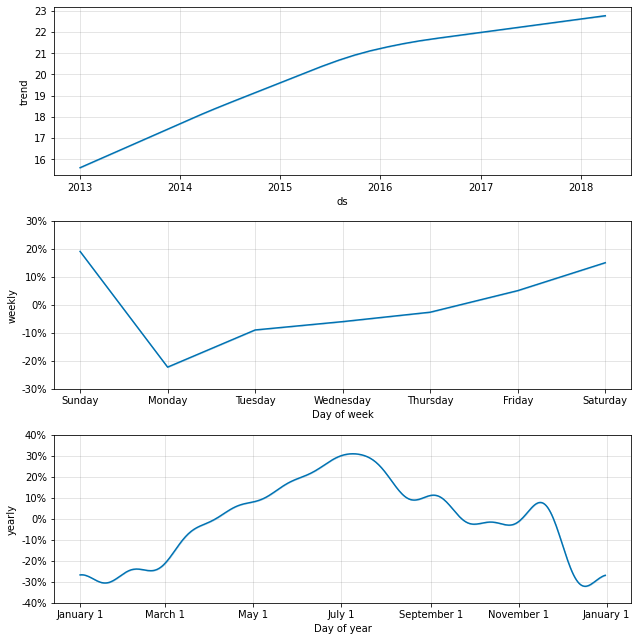

In [31]:
trends_fig = model.plot_components(forecast_pd)

## Step 5:

Compare historicals and predictions.

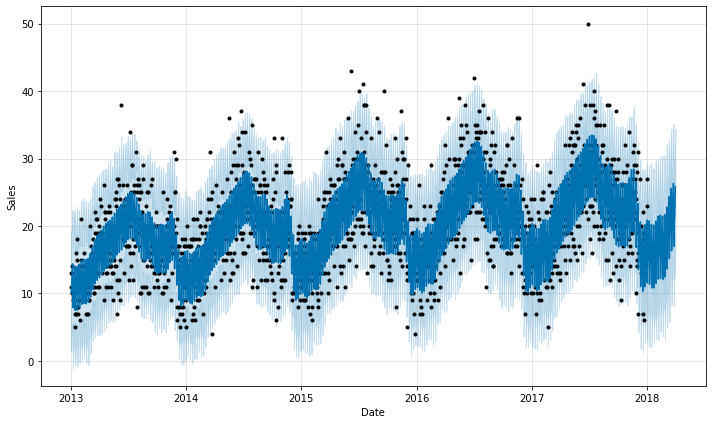

In [52]:
predict_fig = model.plot(forecast_pd, xlabel='Date', ylabel='Sales')

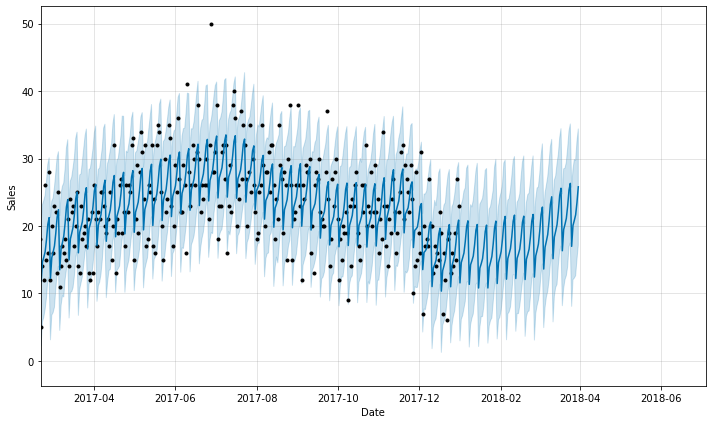

In [53]:
# Zoom in
xlim = predict_fig.axes[0].get_xlim()
new_xlim = (xlim[1]-500, xlim[1])
predict_fig.axes[0].set_xlim(new_xlim)

display(predict_fig)

## Step 6:
Calculate evaluation metrics.

In [54]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date

In [69]:
# Get histocial actuals and predicitons
actuals = history_pd['y']
predictions = forecast_pd[forecast_pd['ds']<=pd.to_datetime(history_pd.tail(1)['ds'].iloc[0])]['yhat']

# Calculate metrics
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = mse**0.5

pd.DataFrame({"MAE":[mae],"MSE":[mse],"RMSE":[rmse]})

,MAE,MSE,RMSE
0,3.48651,19.388673,4.403257
